## Jigsaw Kaggle Competition - WIP 

### Proper commenting and explanation still missing

#!python -m pip install --user gensim
!python -m pip install --user wordcloud
!python -m pip install --user fasttext

In [72]:
import gensim
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from spellchecker import SpellChecker
#import pyspellchecker


In [73]:
from keras.preprocessing.sequence import pad_sequences


#### Intro:
What is the problem?
What is the target?
Who is the team?


#### Outline:
EDA: 
- check submission file
- check test file
- deep dive into the training set
 - visualize additional parameters
 - give some examples
 

#### Preprocessing: 
- Tokenize into list of lists
- put data into a dictionnary with an id for every word
- create a corpus using matrices
    -count (frequency)
    -tfidf (frequency)
    -co-occurence (frequency)
    -naive bayes (propabalistic)
- create a corpus with predictive matrices with neural networks?

- How do we work with contexts

- try out how regression , trees etc. work

- is the language only english?
    

Feature engineering ideas:
- lentgh of comment
- number of missspeling per amount of words
- number of exclamation marks
- translate smilies
- check if there are parents or publications which have higher toxicity and transform that into a constant feature


## Data provided by Kaggle

Can you help detect toxic comments ― and minimize unintended model bias? That's your challenge in this competition.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

Last year, in the Toxic Comment Classification Challenge, you built multi-headed models to recognize toxicity and several subtypes of toxicity. This year's competition is a related challenge: building toxicity models that operate fairly across a diverse range of conversations.

Here’s the background: When the Conversation AI team first built toxicity models, they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted a high likelihood of toxicity for comments containing those identities (e.g. "gay"), even when those comments were not actually toxic (such as "I am a gay woman"). This happens because training data was pulled from available sources where unfortunately, certain identities are overwhelmingly referred to in offensive ways. Training a model from data with these imbalances risks simply mirroring those biases back to users.

In this competition, you're challenged to build a model that recognizes toxicity and minimizes this type of unintended bias with respect to mentions of identities. You'll be using a dataset labeled for identity mentions and optimizing a metric designed to measure unintended bias. Develop strategies to reduce unintended bias in machine learning models, and you'll help the Conversation AI team, and the entire industry, build models that work well for a wide range of conversations.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.
Acknowledgments

The Conversation AI team would like to thank Civil Comments for making this dataset available publicly and the Online Hate Index Research Project at D-Lab, University of California, Berkeley, whose labeling survey/instrument informed the dataset labeling. We'd also like to thank everyone who has contributed to Conversation AI's research, especially those who took part in our last competition, the success of which led to the creation of this challenge. 

Background

At the end of 2017 the Civil Comments platform shut down and chose make their ~2m public comments from their platform available in a lasting open archive so that researchers could understand and improve civility in online conversations for years to come. Jigsaw sponsored this effort and extended annotation of this data by human raters for various toxic conversational attributes.

In the data supplied for this competition, the text of the individual comment is found in the comment_text column. Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data. This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment. For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).



# Import relevant packages

In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# To release RAM import gc collector
import gc
gc.disable()

# Methods

In [75]:
# Reduce memory function was taken from the kaggle following kernel:
# https://www.kaggle.com/ashishpatel26/lightgbm-gbdt-dart-baysian-ridge-reg-lb-3-61
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [76]:
# search for missing data by column, reduce actual methos to save RAM
def missing_values_table(df):
        # Total missing values
        # mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        #mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        #mis_val_table_ren_columns = mis_val_table.rename(
        #columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_percent = mis_val_percent[mis_val_percent != 0].sort_values(ascending=False).round(1)
        
        # Return the dataframe with missing information
        return mis_val_percent
    # search for missing data by column    

# First inspection of the datasets

In [77]:
test_data = pd.read_csv('../s_lohmann18/00_Jigsaw Competition/input/test.csv')
sample_submission = pd.read_csv('../s_lohmann18/00_Jigsaw Competition/input/sample_submission.csv')

print(test_data.head())
print(sample_submission.head(10))

        id  \
0  7000000   
1  7000001   
2  7000002   
3  7000003   
4  7000004   

                                                                                                                                                                                                                                                                                                  comment_text  
0                                                                                                                                                  Jeff Sessions is another one of Trump's Orwellian choices. He believes and has believed his entire career the exact opposite of what the position requires.  
1  I actually inspected the infrastructure on Grand Chief Stewart Philip's home Penticton First Nation in both 2010 and 2013.  Exactly Zero projects that had been identified in previous inspection reports had been funded by the federal government, and the entire band was housed in ATCO trailers.  C...  


In [78]:
# delete test data and the submission file for now
del test_data
del sample_submission
gc.collect

<function gc.collect>

## Inspection of the train dataset

In [79]:
dtypesDict_tr = {
'id'                            :         'int32',
'target'                        :         'float16',
'severe_toxicity'               :         'float16',
'obscene'                       :         'float16',
'identity_attack'               :         'float16',
'insult'                        :         'float16',
'threat'                        :         'float16',
'asian'                         :         'float16',
'atheist'                       :         'float16',
'bisexual'                      :         'float16',
'black'                         :         'float16',
'buddhist'                      :         'float16',
'christian'                     :         'float16',
'female'                        :         'float16',
'heterosexual'                  :         'float16',
'hindu'                         :         'float16',
'homosexual_gay_or_lesbian'     :         'float16',
'intellectual_or_learning_disability':    'float16',
'jewish'                        :         'float16',
'latino'                        :         'float16',
'male'                          :         'float16',
'muslim'                        :         'float16',
'other_disability'              :         'float16',
'other_gender'                  :         'float16',
'other_race_or_ethnicity'       :         'float16',
'other_religion'                :         'float16',
'other_sexual_orientation'      :         'float16',
'physical_disability'           :         'float16',
'psychiatric_or_mental_illness' :         'float16',
'transgender'                   :         'float16',
'white'                         :         'float16',
'publication_id'                :         'int8',
'parent_id'                     :         'float32',
'article_id'                    :         'int32',
'funny'                         :         'int8',
'wow'                           :         'int8',
'sad'                           :         'int8',
'likes'                         :         'int16',
'disagree'                      :         'int16',
'sexual_explicit'               :         'float16',
'identity_annotator_count'      :         'int16',
'toxicity_annotator_count'      :         'int16'
}

In [80]:
# Load the datasets
train_data = pd.read_csv('../s_lohmann18/00_Jigsaw Competition/input/train.csv',dtype=dtypesDict_tr,parse_dates=['created_date'], nrows=700000  )
#train_data.info()

In [81]:
# Use the methos to well import the data
#reduce_mem_usage(train_data)
#train_data.info()

In [82]:
# Look at the top of the dataset
train_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893555,haha you guys are a bunch of losers.,0.021271,0.0,0.021271,0.872559,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [83]:
# Inspect the statistical summary of the dataset
train_data.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,7.000000e+05,700000.000000,700000.000000,700000.0,700000.0,700000.000000,700000.0,158201.0,158201.0,158201.0,...,4.008800e+05,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.0,700000.000000,700000.000000
mean,7.188532e+05,NaN,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,7.161444e+05,160098.309394,0.204021,0.033876,0.081080,2.758094,0.485871,0.0,1.452729,8.690617
std,5.282821e+05,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,4.997098e+05,53057.108013,0.965995,0.221074,0.412678,5.082994,1.881018,0.0,17.869838,41.193389
min,5.984800e+04,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,6.100600e+04,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000
25%,4.558328e+05,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,4.637658e+05,144897.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.000000
50%,6.714810e+05,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,6.759515e+05,154782.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,4.000000
75%,8.860335e+05,0.166626,0.000000,0.0,0.0,0.015625,0.0,0.0,0.0,0.0,...,8.845380e+05,163482.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.0,0.000000,6.000000
max,4.979038e+06,1.000000,0.534668,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,4.978971e+06,317929.000000,102.000000,15.000000,31.000000,300.000000,187.000000,1.0,1860.000000,3509.000000


 ### Information about the additional columns

The data also has several additional toxicity subtype attributes. Models do not need to predict these attributes for the competition, they are included as an additional avenue for research. Subtype attributes are:

    severe_toxicity
    obscene
    threat
    insult
    identity_attack
    sexual_explicit

In [84]:
tox_col = ['severe_toxicity', 'obscene', 'threat','insult','identity_attack','sexual_explicit']

Additionally, a subset of comments have been labelled with a variety of identity attributes, representing the identities that are mentioned in the comment. The columns corresponding to identity attributes are listed below. Only identities with more than 500 examples in the test set (combined public and private) will be included in the evaluation calculation. These identities are shown in bold.

    male
    female
    transgender
    other_gender
    heterosexual
    homosexual_gay_or_lesbian
    bisexual
    other_sexual_orientation
    christian
    jewish
    muslim
    hindu
    buddhist
    atheist
    other_religion
    black
    white
    asian
    latino
    other_race_or_ethnicity
    physical_disability
    intellectual_or_learning_disability
    psychiatric_or_mental_illness
    other_disability

To collect the identity labels, annotators were asked to indicate all identities that were mentioned in the comment. An example question that was asked as part of this annotation effort was: "What genders are mentioned in the comment?"

    Male
    Female
    Transgender
    Other gender
    No gender mentioned

In [85]:
id_attr = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian','bisexual', 'other_sexual_orientation', 'christian','jewish','muslim','hindu','buddhist',
    'atheist','other_religion','black','white', 'asian','latino','other_race_or_ethnicity','physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness','other_disability']

In addition to the labels described above, the dataset also provides metadata from Jigsaw's annotation: toxicity_annotator_count and identity_annotator_count

and metadata from Civil Comments: 
created_date, publication_id, parent_id, article_id, rating, funny, wow, sad, likes, disagree. 
Civil Comments' label rating is the civility rating Civil Comments users gave the comment.

In [86]:
ids = ['article_id', 'parent_id', 'publication_id']
feedback_attr = ['rating','wow', 'funny','sad', 'likes', 'disagree']
other_attr = ['toxicity_annotator_count', 'identity_annotator_count']

Analyse the training data

Check out the y-variable target

To obtain the toxicity labels, each comment was shown to up to 10 annotators*. Annotators were asked to: "Rate the toxicity of this comment"

    Very Toxic (a very hateful, aggressive, or disrespectful comment that is very likely to make you leave a discussion or give up on sharing your perspective)
    Toxic (a rude, disrespectful, or unreasonable comment that is somewhat likely to make you leave a discussion or give up on sharing your perspective)
    Hard to Say
    Not Toxic

## Examples of toxic and non-toxic comments


In [87]:
pd.options.display.max_colwidth=300
# Print the most severe comments to get a feeling for the data but also on the data structure
for n, v in enumerate(train_data.loc[train_data.target>0.8, 'comment_text']):
    print(n, ': ', v)
    if n == 10:
        break


0 :  haha you guys are a bunch of losers.
1 :  Yet call out all Muslims for the acts of a few will get you pilloried.   So why is it okay to smear an entire religion over these few idiots?  Or is this because it's okay to bash Christian sects?
2 :  This bitch is nuts. Who would read a book by a woman.
3 :  You're an idiot.
4 :  Who cares!? Stark trek and Star Wars fans are all dorks who never get laid.
5 :  Nincompoop, that's a nice one! I'm partial to silly goose.
6 :  Sorry to have to do this, but just to see if profanity filtering is enabled: fuck.
7 :  testing purposes: 

you are an idiot and i can't stand ignorant donutholes.
8 :  For the purposes of testing, here's my contribution:

lol wut wat a bunch of bullshit

the author is a delusional stupid jerk full of crap

(I just can't bring myself to use stronger profanity and personal attacks.)
9 :  Well shit, they drafted a guide.  We should all be good now, whew aht a relief...
10 :  Where do you get the Sour Grapes to say this is

In [88]:
pd.options.display.max_colwidth=300
# Print the most severe comments to get a feeling for the data but also on the data structure
for n, v in enumerate(train_data.loc[train_data.target==0.0, 'comment_text']):
    print(n, ': ', v)
    if n == 10:
        break

0 :  This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!
1 :  Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!
2 :  This is such an urgent design problem; kudos to you for taking it on. Very impressive!
3 :  Is this something I'll be able to install on my site? When will you be releasing it?
4 :  FFFFUUUUUUUUUUUUUUU
5 :  The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.
6 :  It was a great show. Not a combo I'd of expected to be good together but it was.
7 :  Wow, that sounds great.
8 :  This seems like a step in the right direction.
9 :  I agree; I don't want to grant them the legitimacy of protestors. They're greedy, small-minded people who somehow seem to share the mass delusion that this is not only a good idea for themselves as individuals, but is the right thing to do for ranchers at large. Basic

## Distribution of the target variable

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


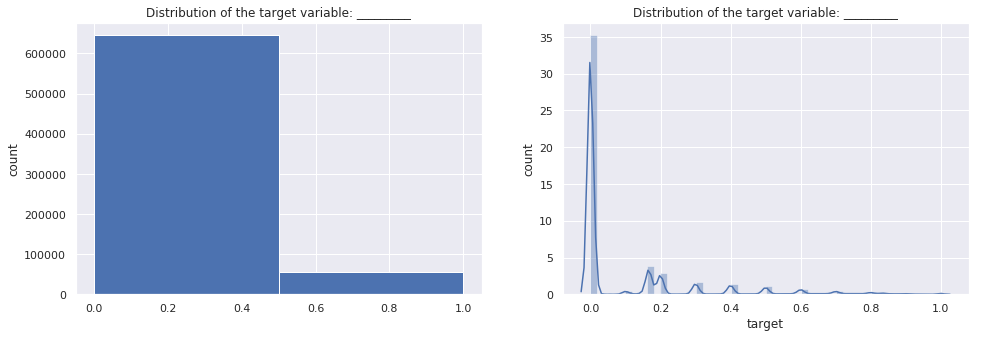

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
ax1.hist(train_data.target, bins=2)
ax1.set_title('Distribution of the target variable: _________')
ax1.set_ylabel('count')

sns.distplot(train_data.target, ax=ax2)
#ax2.hist(train_data.target)
ax2.set_title('Distribution of the target variable: _________')
ax2.set_ylabel('count')

plt.show()

In [90]:
# Analyse the partition of toxicity classification against the full dataset
# As the number of toxic vs non-toxic comments is not euqually balanced we need to consider when interpreting the accuary

columns = ['target','severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat']
toxic_crit = train_data.loc[:, columns]
toxic_crit = toxic_crit>0.5
toxic_crit = toxic_crit.sum()
toxic_crit = toxic_crit.sort_values(ascending = False)

## Distribution of additional columns

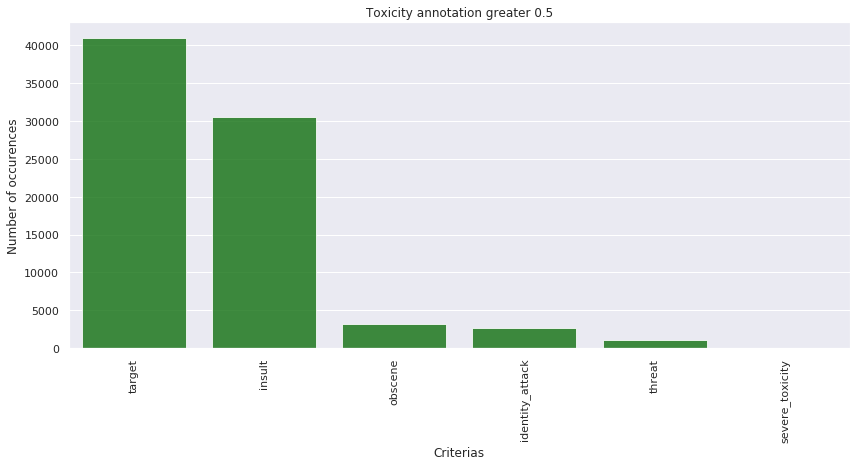

In [91]:
#cnt_srs = test_df['first_active_month'].dt.date.value_counts()
#cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(toxic_crit.index, toxic_crit.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('Criterias', fontsize=12)
plt.ylabel('Number of occurences', fontsize=12)
plt.title("Toxicity annotation greater 0.5")
plt.show()

In [92]:
# Analyse the partition of toxicity classification against the full dataset
# As the number of toxic vs non-toxic comments is not euqually balanced we need to consider when interpreting the accuary

other_attr = train_data.loc[:, id_attr]
other_attr = other_attr>0.5
other_attr = other_attr.sum()
other_attr = other_attr.sort_values(ascending = False)

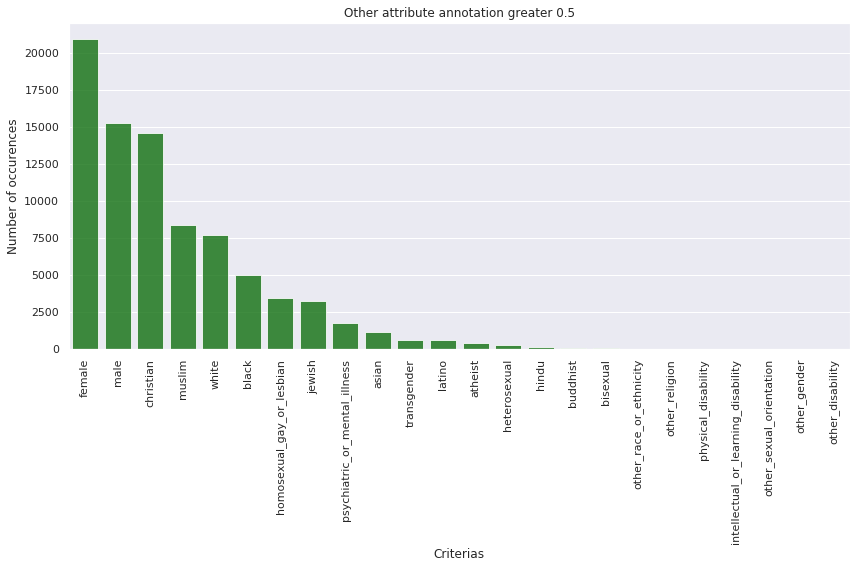

In [93]:
#cnt_srs = test_df['first_active_month'].dt.date.value_counts()
#cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(other_attr.index, other_attr.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('Criterias', fontsize=12)
plt.ylabel('Number of occurences', fontsize=12)
plt.title("Other attribute annotation greater 0.5")
plt.show()

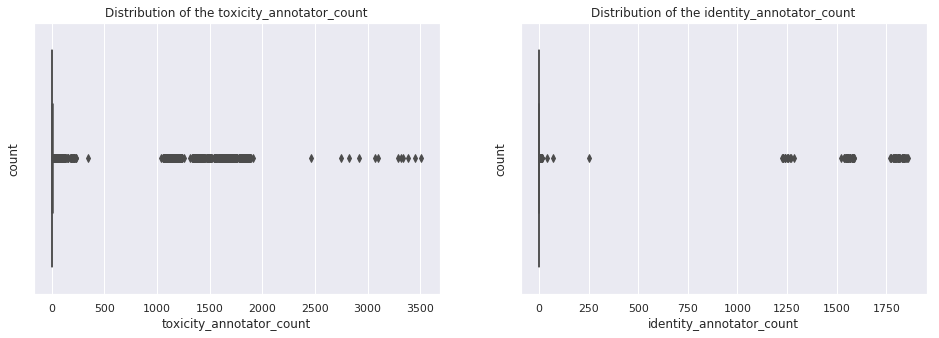

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.boxplot(train_data.toxicity_annotator_count, ax=ax1)
ax1.set_title('Distribution of the toxicity_annotator_count')
ax1.set_ylabel('count')
sns.boxplot(train_data.identity_annotator_count, ax=ax2)
#ax2.hist(train_data.identity_annotator_count)
ax2.set_title('Distribution of the identity_annotator_count')
ax2.set_ylabel('count')

plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
ax1.plot(train_data.target[train_data.female.notnull()], train_data.toxicity_annotator_count[train_data.female.notnull()], ls='None', marker='.', markersize=10, alpha=0.5 )
ax2.plot(train_data.target, train_data.identity_annotator_count, ls='None', marker='.', markersize=10, alpha=0.5 )


## Text preprocessing

Methods

In [95]:
import re

In [96]:
# Tranform text to lower case
train_data.comment_text = train_data.comment_text.apply(lambda x: x.lower())

In [97]:
# Extract all unique characters from the dataset
def extract_used_characters(df):
    used_characters = []
    for i, row in enumerate(df):
        characters = list(row)
        for x in characters:
            if x not in used_characters:
                used_characters.append(x)
                
    return used_characters

# extract all unique words from the dataset
def extract_words(df):
    used_words = []
    for i, row in enumerate(df):
        words = word_tokenize(row.lower())
        for w in words:
            if w not in used_words:
                used_words.append(w)
                
    return used_words



In [98]:
# UExtract all unique characters from the comment text as a basis for translation and/or replacement
characters = extract_used_characters(train_data['comment_text'])
print(characters)

['t', 'h', 'i', 's', ' ', 'o', 'c', 'l', '.', "'", 'k', 'e', ',', 'w', 'u', 'd', 'y', 'a', 'n', 'r', 'm', '?', 'g', '!', 'f', 'x', '-', 'p', 'b', ';', 'v', '*', '"', '…', 'j', ':', '\n', '1', '5', '0', 'q', '—', '(', ')', 'z', '%', '2', '6', '3', '#', '$', '9', '7', '&', '_', '8', '/', '’', '@', '＼', '・', 'ω', '4', '+', '🍕', '=', '”', '“', '[', ']', '^', '–', '>', '\r', '🐵', '\\', '°', '<', '😑', '~', '\xa0', '\ue014', '•', '≠', '‘', 'ï', 'é', '\t', '™', '\uf818', '\uf04a', '\xad', 'ˈ', 'ʊ', 'ɒ', '😢', '🐶', '∞', 'à', '§', '{', '}', '·', 'τ', 'α', '❤', '️', '☺', 'ü', 'ɡ', 'ə', 'ē', '\uf0e0', '😜', 'ç', '😎', '👊', 'ō', '\u200b', '\u200e', 'è', '😁', '|', 'ع', 'د', 'و', 'ي', 'ه', 'ص', 'ق', 'أ', 'ن', 'ا', 'خ', 'ل', 'ى', 'ب', 'م', 'غ', 'ر', '😍', '💖', '¢', '→', '̶', '`', '💵', 'á', 'ú', 'í', '❥', '━', '┣', '┫', 'е', '┗', 'ｏ', '►', '★', '👎', '😀', '😂', '\u202a', '\u202c', '🔥', '😄', '©', '―', '🏻', '💥', 'ᴍ', 'ʏ', 'ʀ', 'ɪ', 'ᴇ', 'ɴ', 'ᴅ', 'ᴏ', 'ᴀ', 'ᴋ', 'ʜ', 'ᴜ', 'ʟ', 'ᴛ', 'ᴄ', 'ᴘ', 'ʙ', 'ғ', 'ᴊ', 'ᴡ',

In [99]:
# convert contradictions before removing symbols
# Add more translations of symbols!!!
contraction_dict = {"#":"","ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)


In [100]:
train_data.comment_text = train_data.comment_text.apply(lambda x: replace_contractions(x))

In [101]:
#Remove all remaining symbols
# Some preprocesssing that will be common to all the text classification methods you will see. 
#https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/

puncts = ["'",',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']', '>', '%', '=', '#', ' # ', '# ','*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, '')
    return x

In [102]:
# Apply text cleaning on comment text
train_data.comment_text = train_data.comment_text.apply(lambda x: clean_text(x))

In [103]:
#https://mlwhiz.com/blog/2019/01/17/deeplearning_nlp_preprocess/
import re
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [104]:
# Remove numbers from comment text
train_data.comment_text = train_data.comment_text.apply(lambda x: clean_numbers(x))

In [105]:
# Lemmatize text to its root words
#https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

def lemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemma.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [106]:
# Apply Lemmatization on comment text
train_data.comment_text = train_data.comment_text.apply(lambda x: lemSentence(x))

#https://pypi.org/project/pyspellchecker/
import pyspellchecker
from spellchecker import SpellChecker

spell = SpellChecker()

def sellCheck(text):
    # find those words that may be misspelled
    misspelled = spell.unknown(text)

    for word in misspelled:
        # Get the one `most likely` answer
        word = spell.correction(word)

In [107]:
for n, v in enumerate(train_data.loc[train_data.target==0.0, 'comment_text']):
    print(n, ': ', v)
    if n == 20:
        break

0 :  this is so cool it is like would you want your mother to read this really great idea well done 
1 :  thank you this would make my life a lot le anxietyinducing keep it up and do not let anyone get in your way 
2 :  this is such an urgent design problem kudos to you for taking it on very impressive 
3 :  is this something i will be able to install on my site when will you be releasing it 
4 :  ffffuuuuuuuuuuuuuuu 
5 :  the rancher seem motivated by mostly by greed no one should have the right to allow their animal destroy public land 
6 :  it wa a great show not a combo i would of expected to be good together but it wa 
7 :  wow that sound great 
8 :  this seems like a step in the right direction 
9 :  i agree i do not want to grant them the legitimacy of protestors they are greedy smallminded people who somehow seem to share the mass delusion that this is not only a good idea for themselves a individual but is the right thing to do for rancher at large basically take something tha

In [108]:
# Check on why the hastags stayed !!

In [109]:
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

stop_words = stopwords.words('english')


In [110]:
# Tokenize the comment text
tok_comments = [word_tokenize(com) for com in train_data.comment_text]


In [111]:
# Remove stopwords
tokens = [[w for w in s if (w not in stop_words) & (len(w)>2)] for s in tok_comments]

In [112]:
from nltk.probability import FreqDist

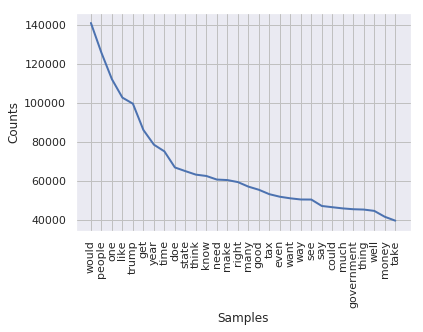

In [113]:
#plot the most frequent words
tokens = np.array([np.array(s) for s in tokens])
fdist = FreqDist(np.concatenate(tokens))
fdist.plot(30,cumulative=False)
plt.show()

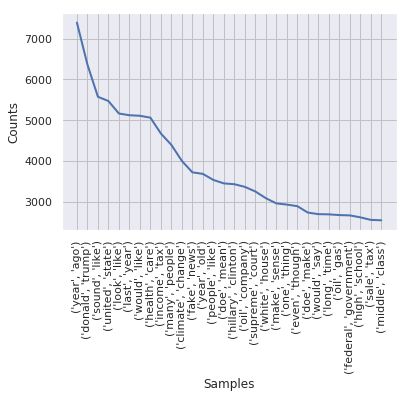

In [114]:
#plot the most frequent word pairs
from nltk import bigrams, ngrams
bigrams_tokens = bigrams(np.concatenate(tokens))
fdist_bigrams = FreqDist(list(bigrams_tokens))
fdist_bigrams.plot(30,cumulative=False)
plt.show()

Correct Misspellings - WIP!

In [115]:
# This comes from CPMP script in the Quora questions similarity challenge. 
import re
from collections import Counter
import gensim
import heapq
from operator import itemgetter
from multiprocessing import Pool

In [116]:
def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


In [117]:
model = gensim.models.KeyedVectors.load_word2vec_format('../s_lohmann18/GoogleNews-vectors-negative300.bin.gz', 
                                                        binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

In [118]:
vocab = fdist

In [119]:
top_10k_words = dict(heapq.nlargest(10000, vocab.items(), key=itemgetter(1)))

In [120]:
pool = Pool(4)
corrected_words = pool.map(correction,list(top_10k_words.keys()))

In [121]:
misspell_dict = {}
for word,corrected_word in zip(top_10k_words,corrected_words):
    if word!=corrected_word:
        misspell_dict[word] = corrected_word

In [122]:
misspell_dict

{'alaskan': 'alaska',
 'juneau': 'bureau',
 'wynne': 'wynn',
 'fairbanks': 'hairbands',
 'oleary': 'bleary',
 'judgement': 'judgment',
 'bannon': 'cannon',
 'favour': 'favor',
 'nra': 'era',
 'behaviour': 'behavior',
 'uaa': 'aa',
 'labour': 'labor',
 'doesnt': 'doesn',
 'didnt': 'didn',
 'ncr': 'nor',
 'hrc': 'arc',
 'djou': 'jou',
 'blm': 'bln',
 'comey': 'come',
 'centre': 'center',
 'assad': 'assay',
 'altright': 'alright',
 'brexit': 'credit',
 'aleppo': 'klepto',
 'parnell': 'panel',
 'oahu': 'bahu',
 'benghazi': 'bengali',
 'wwii': 'wii',
 'isnt': 'int',
 'flynn': 'flyin',
 'defence': 'defense',
 'leitch': 'letch',
 'seward': 'reward',
 'begich': 'begin',
 'kenai': 'kenaf',
 'wavemaker': 'pacemaker',
 'oha': 'oh',
 'neighbour': 'neighbor',
 'adventist': 'advertise',
 'antitrump': 'antitrust',
 'devos': 'demos',
 'oregonian': 'gorgonian',
 'freeland': 'freehand',
 'scotus': 'scouts',
 'tpp': 'top',
 'crimea': 'crime',
 'deplorables': 'deplorable',
 'eweb': 'web',
 'wente': 'went'

In [123]:
#mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)#!!!!
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

# Usage

replace_typical_misspell("Whta is demonstration")

'What is demonstration'

from collections import Counter

from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(tok_comments)

dictionary.token2id

corpus = [dictionary.doc2bow(com) for com in tok_comments]

### Play with word to vector

In [124]:
from gensim.models import Word2Vec

word2vec = Word2Vec(tok_comments, min_count=2)

In [125]:
vocab = word2vec.build_vocab

word2vec_pad = pad_sequences(word2vec)
word2vec_pad

In [126]:
word2vec.most_similar(['toxic'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('radioactive', 0.8062276840209961),
 ('poisonous', 0.7794575691223145),
 ('flammable', 0.7194930911064148),
 ('toxin', 0.7193020582199097),
 ('vapor', 0.7153187990188599),
 ('fertilizer', 0.7099685072898865),
 ('noxious', 0.7087972164154053),
 ('pollutant', 0.6926442384719849),
 ('contaminated', 0.6852533221244812),
 ('hazardous', 0.6759816408157349)]

## First Classification Model

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics


In [128]:
y = np.where(train_data.target>0.5,1, 0 )

Using count vectorizer

In [129]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(train_data.comment_text.values)

In [130]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(count_data, y, test_size=0.2, random_state=42)

In [131]:
log = LogisticRegression()
log.fit(X_train_c, y_train_c)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [132]:
pred = log.predict(X_test_c)
pred_prob = log.predict_proba(X_test_c)

In [133]:
metrics.accuracy_score(y_test_c, pred)

0.9570785714285714

In [134]:
metrics.roc_auc_score(y_test_c, pred)

0.7266188031877833

Using TFIDF Vectorizer

In [135]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_data = tfidf_vectorizer.fit_transform(train_data.comment_text.values)

In [136]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(tfidf_data, y, test_size=0.2, random_state=42)

In [137]:
log = LogisticRegression()
log.fit(X_train_t, y_train_t)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [138]:
pred = log.predict(X_test_t)

In [139]:
metrics.accuracy_score(y_test_t, pred)

0.95955

In [140]:
metrics.roc_auc_score(y_test_t, pred)

0.7020227783162215

## So far model quality very bad comparing to the proportion

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
    
    Build a neural network with embeddings, using Glove, 
    in the last dense leyer we should use sigmoid function!!

Try also LightGBM, Naive Bayes, CNN, RNN